In [23]:
import pdb
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime
import pdb

%matplotlib inline

In [24]:
'''Useful functions'''
def sigmoid(z):
    return 1/ (1+ np.exp(-z))  

def sigmoidPrime(z):
    return np.exp(-z) / ((1+np.exp(-z))**2)

In [50]:
import numpy as np
from numpy.linalg import norm

'''Neural Network parameters'''

class Neural_Network(object):
    def __init__(self, inputLayerSize, outputLayerSize, hiddenLayerSize, Lambda):
        #Define Hyperparameters:
        self.inputLayerSize = inputLayerSize 
        self.outputLayerSize = outputLayerSize
        
        # hidden layers 
        self.nbhiddenLayers = len(hiddenLayerSize)
        self.hiddenLayerSize = hiddenLayerSize
        
        self.Lambda = Lambda
        
        # weights matrices
        # they are randomly initialized here
        self.W = []
        self.W.append(np.random.rand(self.inputLayerSize,self.hiddenLayerSize[0]))
        for i in range(self.nbhiddenLayers - 1):
            self.W.append(np.random.rand(self.hiddenLayerSize[i],self.hiddenLayerSize[i+1]))
        self.W.append(np.random.rand(self.hiddenLayerSize[-1],self.outputLayerSize))

    
    def forward(self, X): 
        # propagate 
        self.z = []
        self.a = []
        X_copy = X
        for i in range(self.nbhiddenLayers+1):
            
            z = np.dot(X_copy, self.W[i])
            a = sigmoid(z)
      
            self.z.append(z)
            self.a.append(a)
            
            X_copy = a
            
        return self.a[-1]
        
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)/X.shape[0] 
        # normlisation : + (self.Lambda/2)*(norm(self.W1)+norm(self.W2)) 
        return J     
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        self.delta = []
        self.dJdW = []
        self.delta.insert(0, np.multiply(-(y-self.yHat), sigmoidPrime(self.z[-1])))
        #Add gradient of regularization term:
        self.dJdW.insert(0,np.dot(self.a[-2].T, self.delta[0])/X.shape[0] )
                    # + self.Lambda*self.W2 regu
        
        for i in range(self.nbhiddenLayers-1,0,-1):            
            self.delta.insert(0, np.dot(self.delta[0], self.W[i+1].T)*sigmoidPrime(self.z[i]))
            #Add gradient of regularization term:
            self.dJdW.insert( 0, np.dot(self.a[i-1].T, self.delta[0])/X.shape[0] )
                             #+ self.Lambda*self.W1 regu
        
        self.delta.insert(0, np.dot(self.delta[0], self.W[1].T)*sigmoidPrime(self.z[0]))
        #Add gradient of regularization term:
        self.dJdW.insert( 0, np.dot(X.T, self.delta[0])/X.shape[0] )
        
    def getParams(self):
        #get W1,W2,..Wi into a flat vector
        params = np.concatenate([array.ravel() for array in NN.W])
        return params
    
    def setParams(self, params):
        #unrolling of Wi... vectors
        W_start = 0
        W_end = self.hiddenLayerSize[0]*self.inputLayerSize
        self.W = []
        self.W.append(np.reshape(params[W_start: W_end], \
                            (self.inputLayerSize,self.hiddenLayerSize[0])))
        for i in range(self.nbhiddenLayers -1):
            W_start = W_end
            W_end = W_end + self.hiddenLayerSize[i]* self.hiddenLayerSize[i+1]
            self.W.append(np.reshape(params[W_start: W_end], \
                            (self.hiddenLayerSize[i],self.hiddenLayerSize[i+1])))
                    
        W_start = W_end
        W_end = W_end + self.hiddenLayerSize[self.nbhiddenLayers -1]* self.outputLayerSize
        self.W.append( np.reshape(params[W_start: W_end], \
                            (self.hiddenLayerSize[self.nbhiddenLayers -1],self.outputLayerSize)) )
    
    def computeGradients(self, X, y):
        # get gradients into a flat vector
        self.costFunctionPrime(X, y)
        return np.concatenate([array.ravel() for array in self.dJdW])

In [54]:
from scipy import optimize
'''Trainer for the Neural Networks'''
class Trainer(object):
    def __init__(self, N):
        self.N = N
    
    def callbackF(self, params):
        # callback function keeping Cost in memory
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))  
    
    def costFunctionWrapper(self, params, X, y):
        # function returning cost and grad
        self.N.setParams(params)
        cost = self.N.costFunction(X,y)
        grad = self.N.computeGradients(X,y)
        return cost, grad
    
    def train(self, X, y):
        
        self.X= X
        self.y= y
        
        # make empty list to store costs
        self.J = []
        params0 = self.N.getParams()
        
        # algo used here is L-BFGS. 
        options ={'maxiter' : 200000, 'disp':True}
        
        _res = optimize.minimize(self.costFunctionWrapper, params0, \
                                jac = False, method ='BFGS', args = (X,y) \
                                 , callback=self.callbackF
                                )
        self.N.setParams(_res.x)
        self.optimizationResults = _res

In [60]:
'''Test of Neural Net'''
n_samples = 1000
inputLayerSize = 5 
outputLayerSize = 1
# hiddenLayerSize = 3
Lambda = 0.0001 
NN = Neural_Network(inputLayerSize = inputLayerSize, outputLayerSize = outputLayerSize, hiddenLayerSize = [1,4,5], Lambda = 0.0001  )
T = Trainer(NN)
X = np.random.rand(n_samples,inputLayerSize)
y = np.random.rand(n_samples,outputLayerSize)
T.train(X, y)

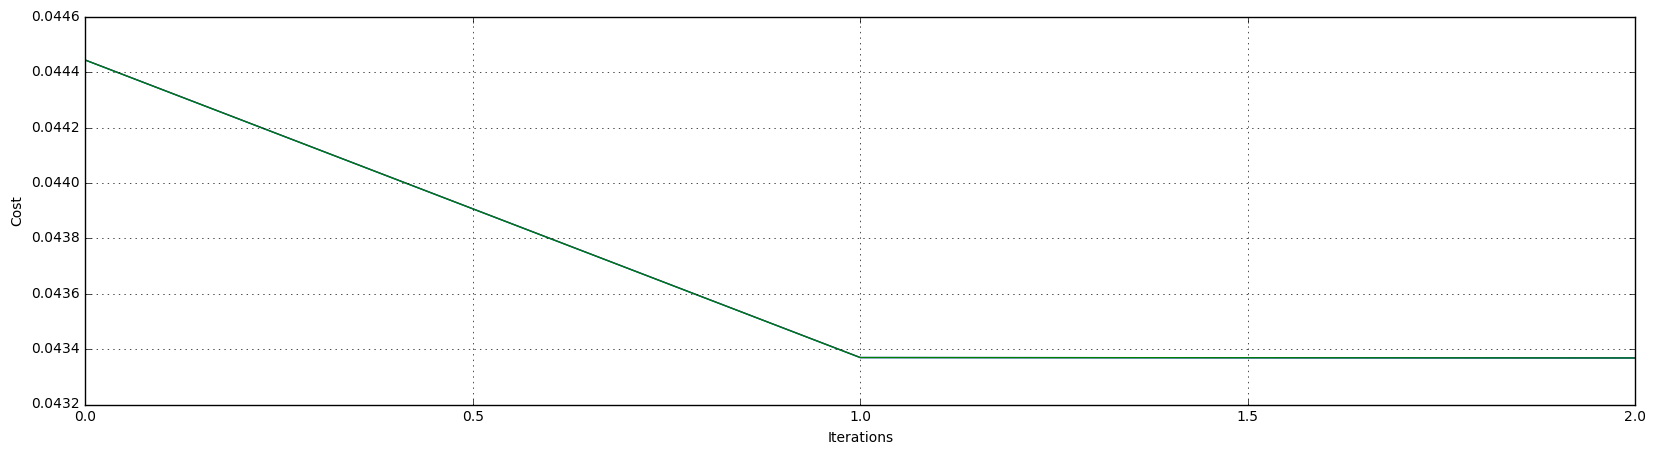

In [61]:
def costplot(cost):
    plt.figure(figsize=(20,5))
    plt.plot(cost)
    plt.plot(cost)
    plt.grid(1)
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
costplot(T.J)

## Prediction for Electricity production

In [62]:
'''Data loading'''
f_names_national = [
    '2012 Conso Prod.csv',
    '2013 Conso Prod.csv',
    '2014 Conso Prod.csv',
    '2015 Conso Prod.csv'
]

datas = []
data_news = []
for f_name in f_names_national:
#     print(f_name)
    data = pd.read_csv('data/'+ f_name, delimiter='\t', encoding = "ISO-8859-1")
    pd.set_option('max_columns', 100)
    headers = list(data)
    data = data[data.Consommation.notnull()]
    data = data[data.Date.notnull()]
    data['timestamp'] = [str(d) + ' ' + str(t) for d, t in zip(data['Date'].values, data['Heures'].values)]
    data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M')
    datas.append(data)

data_final = pd.concat(datas).reset_index()


/home/benlet/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18,19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/benlet/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


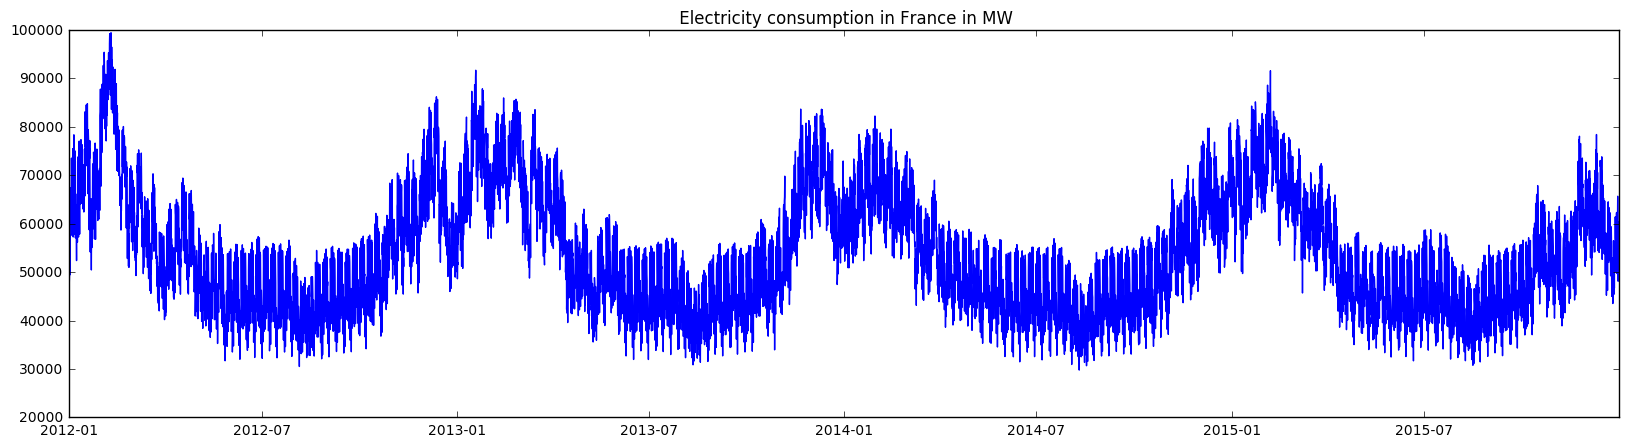

In [64]:
'''Plot of the Electricity Consumption in France over 3 years'''
ts =pd.Series(data_final['Consommation'].values, index = data_final['timestamp'].values )
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(ts[::10].index, ts[::10])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_title(" Electricity consumption in France in MW")


In [86]:
# Sorting values : le premier élement du data set est le plus récent : 
# y(t), y(t-1) etc... 
data_final = data_final.sort_values(by=['Date','Heures'], ascending=[False,False])

In [71]:
'''tau : paramètre de périodicité'''
tau = 48 # 48 : on considère une corrélation de 24h. On pourrait prendre tau = 1 an 
            # afin de correler les données avec les données de l'année passée

def data_labels(dataframe=data_final, field='Consommation', tau = tau):
    X = dataframe[field].values
    X_ = np.stack([np.roll(X,i) for i in range(49)], axis=1)

    labels = X_[:,:1]
    data = X_[:,1:]
    return data, labels


## Generating Training and CV sets

In [92]:
# Creating the training set and the crossvalidation set.
# two years of training, 1 year for cv 
data_train, labels_train = data_labels(dataframe = data_final[data_final['Date'] <= '2014-12-31'])
data_test, labels_test = data_labels(dataframe = data_final[data_final['Date'] > '2014-12-31'])

### Test on Train Data

In [35]:
n_samples = X_train.shape[0]
# inputLayerSize = 2 
# outputLayerSize = 1
# hiddenLayerSize = 3
Lambda = 0.01 
NN = Neural_Network(inputLayerSize = X_train.shape[1], outputLayerSize = 1, hiddenLayerSize = [200,200,10], Lambda = 0.01  )
T = Trainer(NN)

In [36]:
T.train(X_train, Y_train)
plt.figure(figsize=(20,5))
plt.plot(T.J)
plt.plot(T.J)
plt.grid(1)
plt.xlabel('Iterations')
plt.ylabel('Cost')

TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'

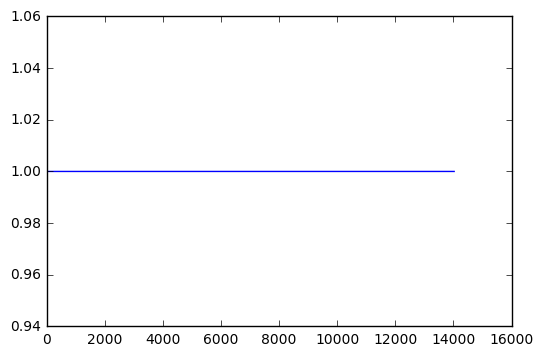

In [15]:
plt.plot(NN.forward(X_test))